## <font color='darkblue'>Introduction</font>
([article source](https://www.analyticsvidhya.com/blog/2020/10/lets-improve-the-model-accuracy-of-imbalanced-covid-19-mortality-prediction-using-generative-adversarial-networks-gan-based-oversampling-technique/) and [corresponding repo](https://github.com/Atharva-Peshkar/Covid-19-Patient-Health-Analytics)) **The article covers the use of [Generative Adversarial Networks](https://en.wikipedia.org/wiki/Generative_adversarial_network)** (<font color='brown'>GAN</font>), **an Oversampling technique on real word skewed Covid-19 data in predicting the risk of mortality.** This story gives us a better understanding of how data preparation steps like handling imbalanced data will improve our model performance.

The data and the core model for this article are considered from the recent study (<font color='brown'>July 2020</font>) on [“COVID-19 Patient Health Prediction Using Boosted Random Forest Algorithm”](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7350612/) by Celestine Iwendi, Ali Kashif Bashir, Atharva Peshkar. et al. **This study used the Random Forest algorithm boosted by the AdaBoost model and predicted the mortality of individual patients with 94% accuracy**. In this article, **the same model and model parameters were considered to clearly analyze the improvement of existing model accuracies by using GAN- based Oversampling Technique**.

**One of the best ways to learn good practices for aspiring Data Scientist would be participating in hackathons on different forums like Analytics Vidhya, Kaggle, or other**. In addition, taking the solved cases and data from these forums or published research publications; **understand their methodology, and try to improve accuracy or reduce the error with additional steps. This will form a strong basis and enable us to think deeply for the application of additional techniques we learned across the value chain of data science.**

**The data used in studies were trained using 222 patient records with 13 features. The data is biased as 159(72%) cases belong to the class "0" or "recovered"**. Due to its skewed nature, various undersampling/oversampling techniques can be applied to the data. The problem of skewness data could lead to overfitting of the prediction model. To overcome this limitation many studies have implemented the use of oversampling methods to provide a balance to the dataset, leading to more accurate model training. **Oversampling is a technique for compensating the imbalance of a dataset, by increasing the number of samples within the minority data**. Conventional methods include Random Oversampling (ROS), [**Synthetic Minority Oversampling Technique**](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (<font color='brown'>SMOTE</font>) and others can be applied. For more information on dealing with imbalanced classes using conventional methods, [refer to here](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

Recently, a machine learning model for developing a generative network based on an adversarial learning concept, namely the [**Generative Adversarial Networks**](https://en.wikipedia.org/wiki/Generative_adversarial_network) (<font color='brown'>GAN</font>), has been proposed. **The characteristic of Generative Adversarial Networks** (<font color='brown'>GAN</font>) **makes it easily applicable to oversampling studies since the nature of the neural network developed based on adversarial training allows artificial data to be made that is similar to the original data.** Oversampling based on Generative Adversarial Networks (<font color='brown'>GAN</font>) overcomes the limitations of conventional methods, such as overfitting, and allows the development of a highly accurate prediction model of imbalanced data.

<a id='sect2'></a>
## <font color='darkblue'>How GAN generate synthetic data</font>
* [**Data Description**](#data_desc)
* [**Defining Generator**](#define_gen)
* [**Defining Discriminator**](#define_dis)
* [**GAN Training**](#gan_train)
* [**Generated data analysis**](#gan_data_analysis)

Two neural networks compete against each other to learn the target distribution and generate artificial data:
* **A generator network `G`**: mimic training samples to fool the discriminator
* **A discriminator network `D`**: discriminate training samples and generated samples

![image1](Images/1.PNG)
<br/>
**Generative adversarial networks are based on a game-theoretic scenario in which the generator network must compete against an adversary**.  As GAN learns to mimic the distribution of data, It is applied in various fields such as music, video, and natural language, and more recently to imbalanced data problems.

The data and the base model used in the study can be found [here](https://github.com/Atharva-Peshkar/Covid-19-Patient-Health-Analytics). First step is to declare the necessary packages:

In [1]:
!pip install pydot

In [2]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers.advanced_activations import LeakyReLU  
from keras.layers.merge import concatenate  
from keras.models import Sequential, Model  
from keras.optimizers import Adam  
from keras.utils import to_categorical  
from keras.layers.advanced_activations import LeakyReLU  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn import preprocessing
import scipy.stats  
import datetime as dt  
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline  

Then it is time to load the training data:

In [3]:
csv_file_path = '../../datas/cov19_train_data.csv'
df = pd.read_csv(csv_file_path)

Next is to clean the data:

In [4]:
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean())  

df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df=df.drop(['sym_on', 'hosp_vis'], axis=1)  
df['location'] = df['location'].astype(str)  
df['country'] = df['country'].astype(str)  
df['gender'] = df['gender'].astype(str)  
df['vis_wuhan'] = df['vis_wuhan'].astype(str)  
df['from_wuhan'] = df['from_wuhan'].astype(str)  
df['symptom1'] = df['symptom1'].astype(str)  
df['symptom2'] = df['symptom2'].astype(str)  
df['symptom3'] = df['symptom3'].astype(str)  
df['symptom4'] = df['symptom4'].astype(str)  
df['symptom5'] = df['symptom5'].astype(str)  
df['symptom6'] = df['symptom6'].astype(str)  
df.dtypes

location         object
country          object
gender           object
age             float64
vis_wuhan        object
from_wuhan       object
death             int64
symptom1         object
symptom2         object
symptom3         object
symptom4         object
symptom5         object
symptom6         object
diff_sym_hos      int64
dtype: object

In [5]:
df.head(n=10)

,location,country,gender,age,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,"Wuhan, Hubei",China,male,61.0,0,1,1,nan,nan,nan,nan,nan,nan,7
1,"Wuhan, Hubei",China,male,69.0,0,1,1,nan,nan,nan,nan,nan,nan,4
2,"Wuhan, Hubei",China,male,89.0,0,1,1,nan,nan,nan,nan,nan,nan,0
3,"Wuhan, Hubei",China,male,89.0,0,1,1,nan,nan,nan,nan,nan,nan,0
4,"Wuhan, Hubei",China,male,66.0,0,1,1,nan,nan,nan,nan,nan,nan,6
5,"Wuhan, Hubei",China,male,75.0,0,1,1,nan,nan,nan,nan,nan,nan,-1
6,"Wuhan, Hubei",China,female,48.0,0,1,1,nan,nan,nan,nan,nan,nan,0
7,"Wuhan, Hubei",China,male,82.0,0,1,1,nan,nan,nan,nan,nan,nan,5
8,"Wuhan, Hubei",China,male,66.0,0,1,1,nan,nan,nan,nan,nan,nan,9
9,"Wuhan, Hubei",China,male,81.0,0,1,1,nan,nan,nan,nan,nan,nan,3


<a id='data_desc'></a>
### <font color='darkgreen'>Data Description</font>

<style> 
table td, table th, table tr {text-align:left !important;}
</style>

| Column | Description | Values (for categorical variables) | Type         
| :---: | :------------- | :---: | :----:
| id |	Patient Id	| NA |	Numeric
| location | The location where the patient belongs to | Multiple cities located throughout the world | String, Categorical
| country | Patient’s native country | Multiple countries | String, Categorical
| gender | Patient’s gender	| Male, Female | String, Categorical
| age | Patient’s age | NA | Numeric
| sym_on | The date patient started noticing the symptoms | NA | Date
| hosp_vis| Date when the patient visited the hospital | NA | Date
| vis_wuhan | Whether the patient visited Wuhan, China | Yes (1), No (0) | Numeric, Categorical
| from_wuhan | Whether the patient belonged to Wuhan, China | Yes (1), No (0) | Numeric, Categorical
| death | Whether the patient passed away due to COVID-19 | Yes (1), No (0) | Numeric, Categorical
| Recov | Whether the patient recovered | Yes (1), No (0) | Numeric, Categorical
| symptom1. symptom2, symptom3, symptom4, symptom5, symptom6 | Symptoms noticed by the patients | Multiple symptoms noticed by the patients | String, Categorical

The study considered 11 categorical and 2 numeric input features for the analysis. **The target variable is death/recovered. A new column ”diff_sym_hos” has been populated to provide the day’s difference between the symptoms being noticed and admitted in the hospital. The focus of the study is on improving the minority class data i.e. death==1, a subset is drawn from the train data.** The subset is separated as categorical and numeric for and passed to the GAN model.

In [6]:
df_minority_data=df.loc[df['death'] == 1]
df_minority_data.shape

(63, 14)

Conduct data preprocessing:

In [7]:
# Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'death']
numerical_df = df_minority_data_withouttv.select_dtypes("number")  
categorical_df = df_minority_data_withouttv.select_dtypes("object")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)  
get_dummy_df = pd.get_dummies(categorical_df)    

# Seperating Each Category
location_dummy_col = [col for col in get_dummy_df.columns if 'location' in col]  
location_dummy = get_dummy_df[location_dummy_col]  
country_dummy_col = [col for col in get_dummy_df.columns if 'country' in col]  
country_dummy = get_dummy_df[country_dummy_col]  
gender_dummy_col = [col for col in get_dummy_df.columns if 'gender' in col]  
gender_dummy = get_dummy_df[gender_dummy_col]  
vis_wuhan_dummy_col = [col for col in get_dummy_df.columns if 'vis_wuhan' in col]  
vis_wuhan_dummy = get_dummy_df[vis_wuhan_dummy_col]  
from_wuhan_dummy_col = [col for col in get_dummy_df.columns if 'from_wuhan' in col]  
from_wuhan_dummy = get_dummy_df[from_wuhan_dummy_col]  
symptom1_dummy_col = [col for col in get_dummy_df.columns if 'symptom1' in col]  
symptom1_dummy = get_dummy_df[symptom1_dummy_col]  
symptom2_dummy_col = [col for col in get_dummy_df.columns if 'symptom2' in col]  
symptom2_dummy = get_dummy_df[symptom2_dummy_col]  
symptom3_dummy_col = [col for col in get_dummy_df.columns if 'symptom3' in col]  
symptom3_dummy = get_dummy_df[symptom3_dummy_col]  
symptom4_dummy_col = [col for col in get_dummy_df.columns if 'symptom4' in col]  
symptom4_dummy = get_dummy_df[symptom4_dummy_col]  
symptom5_dummy_col = [col for col in get_dummy_df.columns if 'symptom5' in col]  
symptom5_dummy = get_dummy_df[symptom5_dummy_col]  
symptom6_dummy_col = [col for col in get_dummy_df.columns if 'symptom6' in col]  
symptom6_dummy = get_dummy_df[symptom6_dummy_col]

In [8]:
get_dummy_df.head()

,location_Hokkaido,location_Hong Kong,location_Hubei,location_Japan,location_Kanagawa,location_Kowloon,location_Manila,location_Paris,location_Qom,location_South Korea,...,symptom2_ fever,symptom2_ pneumonia,symptom2_ shortness of breath,symptom2_nan,symptom3_ pneumonia,symptom3_ sore throat,symptom3_nan,symptom4_nan,symptom5_nan,symptom6_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1


In [9]:
numerical_df.head()

,age,diff_sym_hos
0,61.0,7
1,69.0,4
2,89.0,0
3,89.0,0
4,66.0,6


<a id='define_gen'></a>
### <font color='darkgreen'>Defining Generator</font>
**The generator takes input from latent space and generates new synthetic samples**. The [**leaky rectified linear activation unit**](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU) (<font color='brown'>LeakyReLU</font>) is a good practice to use in both the generator and the discriminator model for handling some negative values. It is used with the default recommended value of 0.2 and the appropriate weight initializer “he_uniform”. **Additionally, batch normalization is used across different layers to standardize the activations** (<font color='brown'>zero mean and unit variance</font>) **from a prior layer and stabilize the training process**.

In the output layer, the [**softmax activation function**](https://en.wikipedia.org/wiki/Softmax_function) is used for categorical variables and [**sigmoid**](https://en.wikipedia.org/wiki/Sigmoid_function) is used for continuous variables.

In [10]:
latent_dim = 100  

def define_generator (
        catsh1, catsh2, catsh3, catsh4, catsh5, catsh6, catsh7, catsh8, catsh9, catsh10, catsh11, 
        numerical, latent_dim=latent_dim
    ):    
    # Inputting noise from latent space
    noise = Input(shape = (latent_dim,))    
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)    
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    

    # Branch 1 for generating location data
    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)    
    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)    
 
    # Output Layer1
    branch_1_output = Dense(catsh1, activation = "softmax")(branch_1)    

    # Branch 2 for generating location data
    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)    
    branch_2 = LeakyReLU(0.2)(branch_2)    
    branch_2 = BatchNormalization(momentum = 0.8)(branch_2)    
    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)    
    branch_2 = LeakyReLU(0.2)(branch_2)    
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)    
 
    # Output Layer2
    branch_2_output = Dense(catsh2, activation = "softmax")(branch_2)
    
    # Branch 3 for generating location data
    branch_3 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)    
    branch_3 = BatchNormalization(momentum = 0.8)(branch_3)    
    branch_3 = Dense(64, kernel_initializer = "he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
 
    # Output Layer3
    branch_3_output = Dense(catsh3, activation = "softmax")(branch_3)
    
    # Branch 4 for generating location data
    branch_4 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_4 = LeakyReLU(0.2)(branch_4)    
    branch_4 = BatchNormalization(momentum = 0.8)(branch_4)
    branch_4 = Dense(64, kernel_initializer = "he_uniform")(branch_4)
    branch_4 = LeakyReLU(0.2)(branch_4)
    branch_4 = BatchNormalization(momentum=0.8)(branch_4)
 
    # Output Layer4
    branch_4_output = Dense(catsh4, activation = "softmax")(branch_4)
    
    # Branch 5 for generating location data
    branch_5 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum = 0.8)(branch_5)
    branch_5 = Dense(64, kernel_initializer = "he_uniform")(branch_5)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum=0.8)(branch_5)
 
    # Output Layer5
    branch_5_output = Dense(catsh5, activation = "softmax")(branch_5)
    
    # Branch 6 for generating location data
    branch_6 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum = 0.8)(branch_6)
    branch_6 = Dense(64, kernel_initializer = "he_uniform")(branch_6)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum=0.8)(branch_6)
 
    # Output Layer6
    branch_6_output = Dense(catsh6, activation = "softmax")(branch_6)
    
    # Branch 7 for generating location data
    branch_7 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum = 0.8)(branch_7)
    branch_7 = Dense(64, kernel_initializer = "he_uniform")(branch_7)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum=0.8)(branch_7)
 
    # Output Layer7
    branch_7_output = Dense(catsh7, activation = "softmax")(branch_7)
    
    # Branch 8 for generating location data
    branch_8 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum = 0.8)(branch_8)
    branch_8 = Dense(64, kernel_initializer = "he_uniform")(branch_8)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum=0.8)(branch_8)
 
    # Output Layer8
    branch_8_output = Dense(catsh8, activation = "softmax")(branch_8)
    
    # Branch 9 for generating location data
    branch_9 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum = 0.8)(branch_9)
    branch_9 = Dense(64, kernel_initializer = "he_uniform")(branch_9)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum=0.8)(branch_9)
 
    # Output Layer9
    branch_9_output = Dense(catsh9, activation = "softmax")(branch_9)
    
    # Branch 10 for generating location data
    branch_10 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum = 0.8)(branch_10)
    branch_10 = Dense(64, kernel_initializer = "he_uniform")(branch_10)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum=0.8)(branch_10)
 
    # Output Layer10
    branch_10_output = Dense(catsh10, activation = "softmax")(branch_10)
    
    # Branch 11 for generating location data
    branch_11 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum = 0.8)(branch_11)
    branch_11 = Dense(64, kernel_initializer = "he_uniform")(branch_11)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum=0.8)(branch_11)
 
    # Output Layer11
    branch_11_output = Dense(catsh11, activation = "softmax")(branch_11)
    
    # Branch 12 for generating numerical data 
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    branch_12 = Dense(128, kernel_initializer = "he_uniform")(branch_12)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    
    # Output Layer12 
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)    

    # Combined output 
    # combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output,branch_4_output,branch_5_output,branch_6_output,branch_7_output,branch_8_output,branch_9_output,branch_10_output,branch_11_output,branch_12_output])    
    combined_output = concatenate([
        branch_1_output,
        branch_2_output,
        branch_3_output,
        branch_4_output,
        branch_5_output,
        branch_6_output,
        branch_7_output,
        branch_8_output,
        branch_9_output,
        branch_10_output,
        branch_11_output,
        branch_12_output
    ])

    # Return model 
    return Model(inputs = noise, outputs = combined_output)    

In [11]:
generator = define_generator(
    location_dummy.shape[1],
    country_dummy.shape[1],
    gender_dummy.shape[1],
    vis_wuhan_dummy.shape[1],
    from_wuhan_dummy.shape[1],
    symptom1_dummy.shape[1],
    symptom2_dummy.shape[1],
    symptom3_dummy.shape[1],
    symptom4_dummy.shape[1],
    symptom5_dummy.shape[1],
    symptom6_dummy.shape[1],
    numerical_df_rescaled.shape[1])  
generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            808         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 8)            0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8)            32          leaky_re_lu[0][0]                
_______________________________________________________________________________________

<a id='define_dis'></a>
### <font color='darkgreen'>Defining Discriminator</font>
The discriminator model will take a sample from our data, such as a vector, and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem, so **sigmoid activation** is used in the output layer and **binary cross-entropy loss function** is used in model compilation. The **Adam optimization algorithm** with the **learning rate LR of 0.0002** and the recommended **beta1 momentum value of 0.5** is used.

In [12]:
def define_discriminator(inputs_n):  
    #Input from generator
    d_input = Input(shape = (inputs_n,))    
    d = Dense(128, kernel_initializer="he_uniform")(d_input)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(64, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(32, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(16, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(8, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)  

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)  
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  
    return model

In [13]:
inputs_n = location_dummy.shape[1] + country_dummy.shape[1] + gender_dummy.shape[1] + \
           vis_wuhan_dummy.shape[1] + from_wuhan_dummy.shape[1] + symptom1_dummy.shape[1] + \
           symptom2_dummy.shape[1] + symptom3_dummy.shape[1] + symptom4_dummy.shape[1] + \
           symptom5_dummy.shape[1] + symptom6_dummy.shape[1] + numerical_df_rescaled.shape[1]  
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               6272      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 32)               

Combining generator and discriminator together as a GAN model and completing the training. **Considered 7,000 epoch’s and considered a complete batch of minority class data for training**.

In [14]:
def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    # Initialize gan
    model = Model(inputs=generator.input, outputs=gan_output)  

    # Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

In [15]:
completegan = define_complete_gan(generator, discriminator)
completegan.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            808         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 8)            0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8)            32          leaky_re_lu[0][0]                
_______________________________________________________________________________________

<a id='gan_train'></a>
### <font color='darkgreen'>GAN Training</font>
Below we define a utility function to train the defined GAN:

In [16]:
def gan_train(gan, generator, discriminator,
              catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,numerical,
              latent_dim, n_epochs, n_batch, n_eval):  
    # Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []
    
    # Generate class labels for fake and real
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    # Training
    for i in range(n_epochs):  
        # Select random batch from real categorical and numerical data
        idx = np.random.randint(0, catsh1.shape[0], half_batch)       
        location_real = catsh1[idx]  
        country_real = catsh2[idx]  
        gender_real = catsh3[idx]  
        vis_wuhan_real = catsh4[idx]  
        from_wuhan_real = catsh5[idx]  
        symptom1_real = catsh6[idx]  
        symptom2_real = catsh7[idx]  
        symptom3_real = catsh8[idx]  
        symptom4_real = catsh9[idx]   
        symptom5_real = catsh10[idx]  
        symptom6_real = catsh11[idx]          
        numerical_real = numerical_df_rescaled[idx]  

        # Concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([
            location_real, country_real, gender_real,
            vis_wuhan_real, from_wuhan_real, 
            symptom1_real,symptom2_real,symptom3_real,symptom4_real,symptom5_real,symptom6_real,numerical_real
        ], axis = 1)
  
        # Generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))  
        fake_data = generator.predict(noise)  
     
        # Train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)  
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        # Generate noise for generator input and train the generator 
        # (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)  

        #evaluate progress
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()

Epoch: 200 [Discriminator loss: 0.541204] [Generator loss: 1.060147]
Epoch: 400 [Discriminator loss: 0.507979] [Generator loss: 1.043759]
Epoch: 600 [Discriminator loss: 0.532084] [Generator loss: 0.979536]
Epoch: 800 [Discriminator loss: 0.621367] [Generator loss: 0.984041]
Epoch: 1000 [Discriminator loss: 0.595122] [Generator loss: 1.000453]
Epoch: 1200 [Discriminator loss: 0.587003] [Generator loss: 1.014305]
Epoch: 1400 [Discriminator loss: 0.449476] [Generator loss: 1.026209]
Epoch: 1600 [Discriminator loss: 0.559061] [Generator loss: 0.982740]
Epoch: 1800 [Discriminator loss: 0.507373] [Generator loss: 0.960440]
Epoch: 2000 [Discriminator loss: 0.586372] [Generator loss: 0.915582]
Epoch: 2200 [Discriminator loss: 0.548591] [Generator loss: 0.969664]
Epoch: 2400 [Discriminator loss: 0.596243] [Generator loss: 1.013127]
Epoch: 2600 [Discriminator loss: 0.518712] [Generator loss: 0.983139]
Epoch: 2800 [Discriminator loss: 0.570600] [Generator loss: 0.936839]
Epoch: 3000 [Discriminat

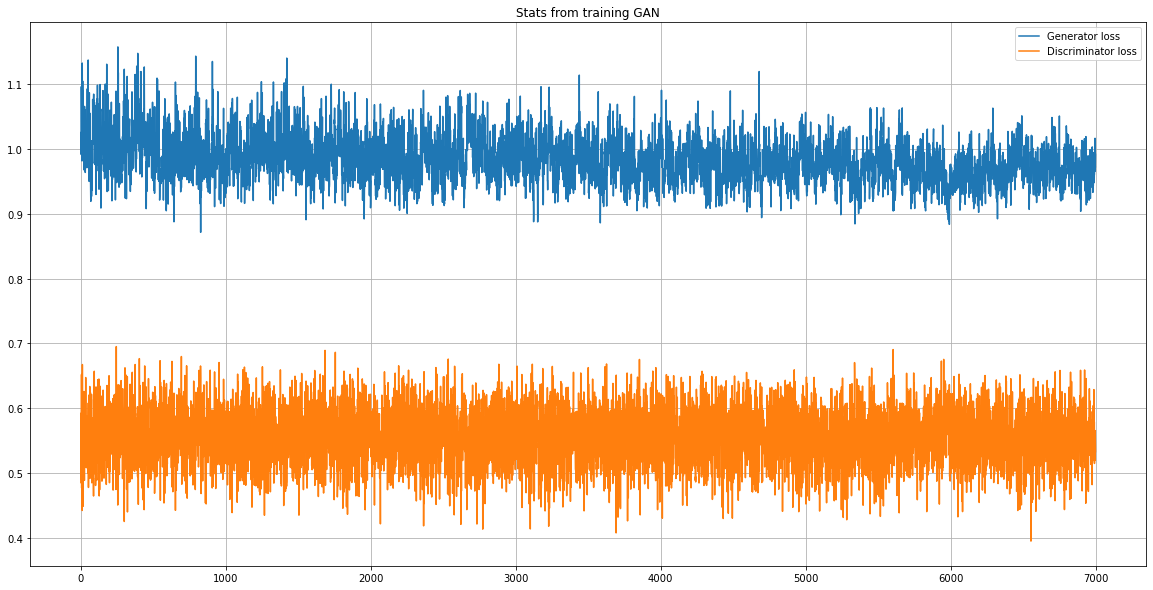

In [19]:
%%time
gan_train(
    completegan, generator, discriminator, 
    location_dummy.values, country_dummy.values,
    gender_dummy.values, vis_wuhan_dummy.values,
    from_wuhan_dummy.values, 
    symptom1_dummy.values, symptom2_dummy.values,
    symptom3_dummy.values, symptom4_dummy.values,
    symptom5_dummy.values, symptom6_dummy.values,
    numerical_df_rescaled, 
    latent_dim, n_epochs = 7000, n_batch = 63, n_eval = 200
)

<a id='gan_data_analysis'></a>
### <font color='darkgreen'>Generated data analysis</font>
**The trained model is used for generating additional 96 records of a minority class to make an equal split** (<font color='brown'>159</font>) **of each class.**  Now comparing generated numeric data with original data mean, standard deviation, and variance; and categorical data are compared on the basis of the count of each category.

In [20]:
noise = np.random.normal(0, 1, (96, latent_dim))  
generated_mixed_data = generator.predict(noise)  
columns = list(location_dummy.columns) + \
          list(country_dummy.columns) + \
          list(gender_dummy.columns) + list(vis_wuhan_dummy.columns) + \
          list(from_wuhan_dummy.columns) + list(symptom1_dummy.columns) + \
          list(symptom2_dummy.columns) + list(symptom3_dummy.columns) + \
          list(symptom4_dummy.columns) + list(symptom5_dummy.columns) + \
          list(symptom6_dummy.columns) + list(numerical_df.columns)

mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)  
mixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3])  
mixed_gen_df.iloc[:,-2:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-2:])
mixed_gen_df.iloc[:,-1] = np.round(mixed_gen_df.iloc[:,-1])
mixed_gen_df.iloc[:,-2] = np.round(mixed_gen_df.iloc[:,-2])
mixed_gen_df.iloc[:,-1] = mixed_gen_df.iloc[:,-1].astype(int)

for c in mixed_gen_df.columns:
    if c.startswith('location_') or c.startswith('country_') or c.startswith('gender_') or \
       c.startswith('vis_wuhan_') or c.startswith('from_wuhan_') or c.startswith('symptom'):
        mixed_gen_df[c] = mixed_gen_df[c].astype(int)

In [21]:
mixed_gen_df.head()

,location_Hokkaido,location_Hong Kong,location_Hubei,location_Japan,location_Kanagawa,location_Kowloon,location_Manila,location_Paris,location_Qom,location_South Korea,...,symptom2_ shortness of breath,symptom2_nan,symptom3_ pneumonia,symptom3_ sore throat,symptom3_nan,symptom4_nan,symptom5_nan,symptom6_nan,age,diff_sym_hos
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,76.0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,79.0,3
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,1,42.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,63.0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,78.0,6


In [22]:
#Original Data
original_df = pd.concat([
    location_dummy, country_dummy, gender_dummy, vis_wuhan_dummy, from_wuhan_dummy,
    symptom1_dummy, symptom2_dummy, symptom3_dummy, symptom4_dummy, symptom5_dummy,
    symptom6_dummy,numerical_df
], axis = 1)  
original_df.head()

,location_Hokkaido,location_Hong Kong,location_Hubei,location_Japan,location_Kanagawa,location_Kowloon,location_Manila,location_Paris,location_Qom,location_South Korea,...,symptom2_ shortness of breath,symptom2_nan,symptom3_ pneumonia,symptom3_ sore throat,symptom3_nan,symptom4_nan,symptom5_nan,symptom6_nan,age,diff_sym_hos
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,61.0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,69.0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,89.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,89.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,66.0,6


In [23]:
def normal_distribution(org, noise):  
    org_x = np.linspace(org.min(), org.max(), len(org))  
    noise_x = np.linspace(noise.min(), noise.max(), len(noise))  
    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  
    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  
    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  
    xmin, xmax = plt.xlim()  
    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  
    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  
    title = f"Original data mean {org.mean():.02f}, Original data std {org.std():.02f}, Original data var {org.var():.02f}\n" \
            f"Generated data mean {noise.mean():.02f}, Generated data std {noise.std():.02f}, Generated data var {noise.var():.02f}"
    plt.title(title)  
    plt.legend()  
    plt.grid()  
    plt.show() 

age Comparison between Original Data and Generated Data


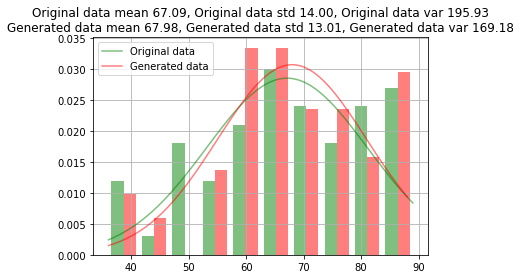

diff_sym_hos Comparison between Original Data and Generated Data


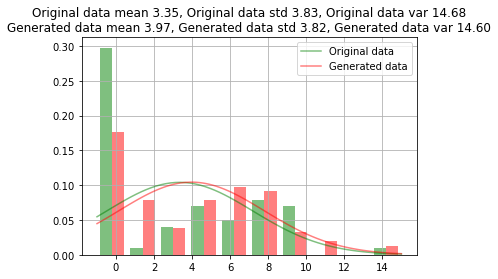

In [24]:
Numeric_columns=numerical_df.columns  

for column in numerical_df.columns:  
    print(column, "Comparison between Original Data and Generated Data")  
    normal_distribution(original_df[column] , mixed_gen_df[column])

Random Categories Comparison between Original Data and Generated Data Comparison between Original Data and Generated Data:

In [25]:
# Original data dist
original_df['location_South Korea'].value_counts()

0    54
1     9
Name: location_South Korea, dtype: int64

In [26]:
# Generated data dist
mixed_gen_df['location_South Korea'].value_counts()

0    96
Name: location_South Korea, dtype: int64

**The data generated from the GAN oversampling method is almost similar to the original data which has an error of approximately 1%.** For a few rare categories, data is not generated across all category values.

Following the same data preparation steps as mentioned in the original study to see how model performance has increased from the original methodology by using GAN oversampling. One hot coded data of the generated sample is converted to the original data frame format.

In [27]:
# Getting Back Categorical Data in Original_Format from Dummies
location_filter_col = [col for col in mixed_gen_df if col.startswith('location')]  
location = mixed_gen_df[location_filter_col]   
location = pd.get_dummies(location).idxmax(1)  
location = location.replace('location_', '', regex=True)  
df_generated_data = pd.DataFrame()   
df_generated_data['location'] = location  

country_filter_col = [col for col in mixed_gen_df if col.startswith('country')]  
country = mixed_gen_df[country_filter_col]   
country = pd.get_dummies(country).idxmax(1)  
country = country.replace('country_', '', regex=True)  
df_generated_data['country'] = country  

gender_filter_col = [col for col in mixed_gen_df if col.startswith('gender')]  
gender = mixed_gen_df[gender_filter_col]   
gender = pd.get_dummies(gender).idxmax(1)  
gender = gender.replace('gender_', '', regex=True)  
df_generated_data['gender'] = gender  

vis_wuhan_filter_col = [col for col in mixed_gen_df if col.startswith('vis_wuhan')]  
vis_wuhan = mixed_gen_df[vis_wuhan_filter_col]   
vis_wuhan = pd.get_dummies(vis_wuhan).idxmax(1)  
vis_wuhan = vis_wuhan.replace('vis_wuhan_', '', regex=True)  
df_generated_data['vis_wuhan'] = vis_wuhan  

from_wuhan_filter_col = [col for col in mixed_gen_df if col.startswith('from_wuhan')]  
from_wuhan=mixed_gen_df[from_wuhan_filter_col]   
from_wuhan= pd.get_dummies(from_wuhan).idxmax(1)  
from_wuhan= from_wuhan.replace('from_wuhan_', '', regex=True)  
df_generated_data['from_wuhan']=from_wuhan  

symptom1_filter_col = [col for col in mixed_gen_df if col.startswith('symptom1')]  
symptom1=mixed_gen_df[symptom1_filter_col]   
symptom1= pd.get_dummies(symptom1).idxmax(1)  
symptom1= symptom1.replace('symptom1_', '', regex=True)  
df_generated_data['symptom1']=symptom1  

symptom2_filter_col = [col for col in mixed_gen_df if col.startswith('symptom2')]  
symptom2=mixed_gen_df[symptom2_filter_col]   
symptom2= pd.get_dummies(symptom2).idxmax(1)  
symptom2= symptom2.replace('symptom2_', '', regex=True)  
df_generated_data['symptom2']=symptom2  

symptom3_filter_col = [col for col in mixed_gen_df if col.startswith('symptom3')]  
symptom3=mixed_gen_df[symptom3_filter_col]   
symptom3= pd.get_dummies(symptom3).idxmax(1)  
symptom3= symptom3.replace('symptom3_', '', regex=True)  
df_generated_data['symptom3']=symptom3  

symptom4_filter_col = [col for col in mixed_gen_df if col.startswith('symptom4')]  
symptom4=mixed_gen_df[symptom4_filter_col]   
symptom4= pd.get_dummies(symptom4).idxmax(1)  
symptom4= symptom4.replace('symptom4_', '', regex=True)  
df_generated_data['symptom4']=symptom4  

symptom5_filter_col = [col for col in mixed_gen_df if col.startswith('symptom5')]  
symptom5=mixed_gen_df[symptom5_filter_col]   
symptom5= pd.get_dummies(symptom5).idxmax(1)  
symptom5= symptom5.replace('symptom5_', '', regex=True)  
df_generated_data['symptom5']=symptom5  

symptom6_filter_col = [col for col in mixed_gen_df if col.startswith('symptom6')]  
symptom6=mixed_gen_df[symptom6_filter_col]   
symptom6= pd.get_dummies(symptom6).idxmax(1)  
symptom6= symptom6.replace('symptom6_', '', regex=True)  
df_generated_data['symptom6']=symptom6  

df_generated_data['death']=1  
df_generated_data['death']=1  

df_generated_data[['age','diff_sym_hos']]=mixed_gen_df[['age','diff_sym_hos']]  
df_generated_data = df_generated_data.fillna(np.nan,axis=0) 

In [28]:
df_generated_data.head(n=10)

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,death,age,diff_sym_hos
0,Hubei,China,male,0,0,nan,nan,nan,nan,nan,nan,1,76.0,6
1,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,79.0,3
2,Manila,Phillipines,male,0,1,fever,cough,sore throat,nan,nan,nan,1,42.0,0
3,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,63.0,6
4,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,78.0,6
5,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,59.0,5
6,Hubei,China,male,0,0,nan,nan,nan,nan,nan,nan,1,36.0,3
7,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,65.0,-1
8,Hubei,China,female,0,0,nan,nan,nan,nan,nan,nan,1,82.0,2
9,"Wuhan, Hubei",China,male,0,1,nan,nan,nan,nan,nan,nan,1,63.0,3


In [29]:
# Encoding Data
encoder_location = preprocessing.LabelEncoder()  
encoder_country = preprocessing.LabelEncoder()  
encoder_gender = preprocessing.LabelEncoder()  
encoder_symptom1 = preprocessing.LabelEncoder()  
encoder_symptom2 = preprocessing.LabelEncoder()  
encoder_symptom3 = preprocessing.LabelEncoder()  
encoder_symptom4 = preprocessing.LabelEncoder()  
encoder_symptom5 = preprocessing.LabelEncoder()  
encoder_symptom6 = preprocessing.LabelEncoder()  

In [30]:
# Loading and Preparing Data
df = pd.read_csv(csv_file_path)  
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean())  
df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df = df.drop(['sym_on','hosp_vis'],axis=1)

df['location'] = encoder_location.fit_transform(df['location'].astype(str))  
df['country'] = encoder_country.fit_transform(df['country'].astype(str))  
df['gender'] = encoder_gender.fit_transform(df['gender'].astype(str))  
df[['symptom1']] = encoder_symptom1.fit_transform(df['symptom1'].astype(str))  
df[['symptom2']] = encoder_symptom2.fit_transform(df['symptom2'].astype(str))  
df[['symptom3']] = encoder_symptom3.fit_transform(df['symptom3'].astype(str))  
df[['symptom4']] = encoder_symptom4.fit_transform(df['symptom4'].astype(str))  
df[['symptom5']] = encoder_symptom5.fit_transform(df['symptom5'].astype(str))  
df[['symptom6']] = encoder_symptom6.fit_transform(df['symptom6'].astype(str))

In [31]:
df.head(n=10)

,location,country,gender,age,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,38,2,1,61.0,0,1,1,9,9,11,0,0,0,7
1,38,2,1,69.0,0,1,1,9,9,11,0,0,0,4
2,38,2,1,89.0,0,1,1,9,9,11,0,0,0,0
3,38,2,1,89.0,0,1,1,9,9,11,0,0,0,0
4,38,2,1,66.0,0,1,1,9,9,11,0,0,0,6
5,38,2,1,75.0,0,1,1,9,9,11,0,0,0,-1
6,38,2,0,48.0,0,1,1,9,9,11,0,0,0,0
7,38,2,1,82.0,0,1,1,9,9,11,0,0,0,5
8,38,2,1,66.0,0,1,1,9,9,11,0,0,0,9
9,38,2,1,81.0,0,1,1,9,9,11,0,0,0,3


In [32]:
# Encoding Generated Data  
df_generated_data['location'] = encoder_location.transform(df_generated_data['location'].astype(str))  
df_generated_data['country'] = encoder_country.transform(df_generated_data['country'].astype(str))  
df_generated_data['gender'] = encoder_gender.transform(df_generated_data['gender'].astype(str))  
df_generated_data[['symptom1']] = encoder_symptom1.transform(df_generated_data['symptom1'].astype(str))  
df_generated_data[['symptom2']] = encoder_symptom2.transform(df_generated_data['symptom2'].astype(str))  
df_generated_data[['symptom3']] = encoder_symptom3.transform(df_generated_data['symptom3'].astype(str))  
df_generated_data[['symptom4']] = encoder_symptom4.transform(df_generated_data['symptom4'].astype(str))  
df_generated_data[['symptom5']] = encoder_symptom5.transform(df_generated_data['symptom5'].astype(str))  
df_generated_data[['symptom6']] = encoder_symptom6.transform(df_generated_data['symptom6'].astype(str))  
df_generated_data[['diff_sym_hos']] = df_generated_data['diff_sym_hos'].astype(int)

In [33]:
df_generated_data.head(n=10)

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,death,age,diff_sym_hos
0,6,2,1,0,0,9,9,11,0,0,0,1,76.0,6
1,38,2,1,0,1,9,9,11,0,0,0,1,79.0,3
2,18,10,1,0,1,5,1,9,0,0,0,1,42.0,0
3,38,2,1,0,1,9,9,11,0,0,0,1,63.0,6
4,38,2,1,0,1,9,9,11,0,0,0,1,78.0,6
5,38,2,1,0,1,9,9,11,0,0,0,1,59.0,5
6,6,2,1,0,0,9,9,11,0,0,0,1,36.0,3
7,38,2,1,0,1,9,9,11,0,0,0,1,65.0,-1
8,6,2,0,0,0,9,9,11,0,0,0,1,82.0,2
9,38,2,1,0,1,9,9,11,0,0,0,1,63.0,3


<a id='model_comp'></a>
## <font color='darkblue'>Model Comparison</font>
After splitting the original data into train and test, generated data from GAN is added to the train data to compare the performance with the base model. The model performance is tested on the actual (original) split test data.

In [34]:
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as fs  
from sklearn.metrics import balanced_accuracy_score as bas  
from sklearn.metrics import confusion_matrix as cm  
import numpy as np  
import pandas as pd  
import datetime as dt  
import sklearn  
from scipy import stats  
from sklearn import preprocessing  
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as fs  
from sklearn.metrics import log_loss  

In [35]:
# Classifier
rf = RandomForestClassifier(
    bootstrap=True, ccp_alpha=0.0, class_weight=None,  
    criterion='gini', max_depth=2, max_features='auto',  
    max_leaf_nodes=None, max_samples=None,  
    min_impurity_decrease=0.0, min_impurity_split=None,  
    min_samples_leaf=2, min_samples_split=2,  
    min_weight_fraction_leaf=0.0, n_estimators=100,  
    n_jobs=None, oob_score=False, random_state=None,  
    verbose=0, warm_start=False
)
classifier = AdaBoostClassifier(rf, 50, 0.01, 'SAMME.R', 10)  

In [36]:
# Seperate TV in Generated Data
X1 = df_generated_data.loc[:, df_generated_data.columns != 'death']  
Y1 = df_generated_data['death']  

# Seperate TV in Original Data
X = df.loc[:, df.columns != 'death']  
Y = df['death']  

In [37]:
# Splitting Original Data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)  

In [38]:
# Appending Generated Data to X_train
X_train1 = X_train.append(X1, sort=False)  
Y_train1 = Y_train.append(Y1)  

In [39]:
# Training
classifier.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))  

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2,
                                                         min_samples_leaf=2),
                   learning_rate=0.01, random_state=10)

In [40]:
# Prediction
pred = np.array(classifier.predict(X_test))  

In [41]:
recall = rs(Y_test,pred)  
precision = ps(Y_test,pred)  
f1 = fs(Y_test,pred)  
ma = classifier.score(X_test,Y_test)  
print('*** Evaluation metrics for test dataset ***\n')  
print(f'Recall Score: {recall:.02f}',)  
print(f'Precision Score: {precision:.02f}')  
print(f'F1 Score: {f1:.02f}')
print(f'Accuracy: {ma:.02f}')

*** Evaluation metrics for test dataset ***

Recall Score: 0.75
Precision Score: 1.00
F1 Score: 0.86
Accuracy: 0.93


| Metric| Score of Base Model*|	Score with Augmented Generated Data
| :---: | :------------------ | :---: 
|Recall Score |	0.75 | 0.83
|Precision Score |1 |1
|F1 Score | 0.86 | 0.9
|Accuracy | 0.9 | 0.95

## <font color='darkblue'>Conclusion</font>
The proposed model provides a more accurate and robust result compared to that of the based model, showing that **GAN-based oversampling overcomes the limitations of the imbalanced data and it appropriately inflates the minority class**.